In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
import re
from itertools import chain
from collections import Counter
import torch.nn as nn
import glob
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import transformers
from transformers import AdamW
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset, random_split
from tqdm import tqdm
import time

In [2]:
# specify device
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Load the BERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Bert mode
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
class DescriptionDataset(Dataset):
    
    """Description dataset without species names."""
    
    def __init__(self, root_dir):
        
        self.root_dir = root_dir
        self.samples = []
        self._init_dataset()
        
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        return self.samples[idx]
     
    def _init_dataset(self):
        
        # Load the pickle list
        datalist = glob.glob(self.root_dir + 'train*.pkl')
        # Init list
        data_values = []
        # Loop over the pickles
        for data in datalist:
            # Open the pickles
            datadict = pickle.load(open(data, 'rb'))
            # Undict and append
            data_values += (list(chain.from_iterable(datadict.values())))
        
        # Drop double values 
        data_values = list(set(data_values))
        
        nested_values = [[tuple([1, span]) if text[0] == 1 else tuple([0, span]) 
                          for span in self.random_text_splitter(text[1])] 
                         for text in data_values]
        
        self.samples += list(chain.from_iterable(nested_values))
        
    def random_text_splitter(self, text):

        import random

        """
        Random breaks up a text into an X amount of sentences. 
        The output sentences consist of a minimum of 10 sentences.
        """

        # Split text
        words = text.split()
        # Get the amount of words
        word_amount = len(words)
        if word_amount <= 10:
            return [text]
        
        # Create counter
        remaining_word_amount = word_amount
        # Init list
        parts = []
        # While words remaining
        while remaining_word_amount > 0:
            if len(words) < 10:
                # Add last part if less then 10
                parts[-1] = parts[-1] + ' '.join(words)
                # exit
                break
            # Generate random int
            randint = random.randint(10, word_amount)
            if randint > 512:
                randint = 512
            # Append to list 
            parts.append(' '.join(words[:randint]))
            # Delete previous selection
            words = words[randint:]
            # Update counter
            remaining_word_amount -= randint

        return parts

In [5]:
try:
    # Colab
    from google.colab import drive
    root = '/content/gdrive/My Drive/'
    drive.mount('/content/gdrive')
    print('Mounted @Google')
except:
    # Local
    root = "../data/processed/"
    print('Mounted @Local')

start = time.time()
# Load data
data = DescriptionDataset(root)
end = time.time()
print("Time consumed in working: ",end - start)

Mounted @Local
Time consumed in working:  20.25885796546936


In [6]:
# Inspect the data
ones = Counter(ones[0] for ones in tqdm(data) if ones[0] == 1)
zeros = Counter(ones[0] for ones in tqdm(data) if ones[0] == 0)

print('{0} samples.'. format(len(data)))
print('{0} labels with 1 (true).'.format(ones[1]))
print('{0} labels with 0 (false).'.format(zeros[0]))

100%|████████████████████████| 1867739/1867739 [00:01<00:00, 1781705.92it/s]

1867739 samples.
451352 labels with 1 (true).
1416387 labels with 0 (false).


In [7]:
# Plot the statistics of the set
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


temp = {}
temp[0] = []
temp[1] = []

# Change this to the dissimilar in future
temp[0] += [len(sents.split()) for key, sents in tqdm(data) if key == 0]
temp[1] += [len(sents.split()) for key, sents in tqdm(data) if key == 1]

100%|█████████████████████████| 1867739/1867739 [00:02<00:00, 862127.46it/s]


In [8]:
print(sorted(temp[0])[-10:])
print(sorted(temp[0])[0:10])


[512, 512, 512, 512, 512, 513, 514, 516, 518, 520]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(0.0, 250000.0)

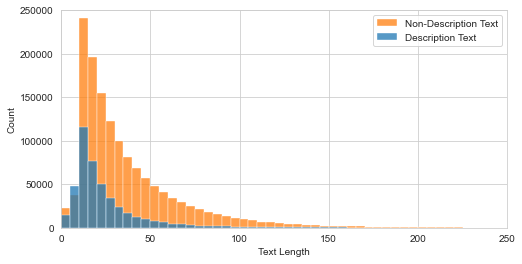

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.set_style('whitegrid')
ax = sns.histplot(temp, hue_order=[1, 0], binwidth=5)
#ax.set_title('Histogram')
ax.legend(labels=["Non-Description Text",
                  "Description Text"])
ax.set(xlabel='Text Length', ylabel='Count')
plt.xlim(0, 250)
plt.ylim(0, 250000)

In [10]:
fig.savefig('histogram_text_length.svg', format='svg', dpi=1200, bbox_inches='tight')

In [9]:
total_count = len(data[0:5000])
train_count = int(0.8 * total_count)
valid_count = int(0.1 * total_count)
test_count = total_count - train_count - valid_count
train_dataset, valid_dataset, test_dataset = random_split(data[0:5000], (train_count, valid_count, test_count), 
                                                       generator=torch.Generator().manual_seed(33))

In [10]:
batch_size = 1

# Random sample (skewed set)
train_sampler = RandomSampler(train_dataset)
# DataLoader for train set
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Random sample
val_sampler = SequentialSampler(valid_dataset)
# DataLoader for validation set
val_dataloader = DataLoader(valid_dataset, sampler=val_sampler, batch_size=batch_size)

In [11]:
# Freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [12]:
class BERT(nn.Module):
    def __init__(self, bert):
        
        super(BERT, self).__init__()
        
        # Distil Bert model
        self.bert = bert
        ## Additional layers
        # Dropout layer
        self.dropout = nn.Dropout(0.1)
        # Relu 
        self.relu =  nn.ReLU()
        # Linear I 
        self.fc1 = nn.Linear(768, 512)
        # Linear II (Out)
        self.fc2 = nn.Linear(512, 2)
        # Softmax
        self.softmax = nn.LogSoftmax(dim=1)
        #self.sigmoid = nn.Sigmoid()


    # Forward pass
    def forward(self, sent_id, mask):

        # Pass data trough bert and extract 
        cls_hs = self.bert(sent_id, attention_mask=mask)
        # Extract hidden state
        hidden_state = cls_hs[0]
        # Only first is needed for classification
        pooler = hidden_state[:, 0]
        
        # Dense layer 1        
        x = self.fc1(pooler)
        # ReLU activation
        x = self.relu(x)
        # Drop out
        x = self.dropout(x)
        # Dense layer 2
        x = self.fc2(x)
        # Activation
        x = self.softmax(x)
        #x = self.sigmoid(x)

        return x

In [13]:
# Load the entire model
model = BERT(bert)

# Load trained model (colab)
try:
    try:
        model_save_name = 'saved_weights.pt'
        path = F"/content/gdrive/My Drive/{model_save_name}"
        model.load_state_dict(torch.load(path))
        print('Google Success')

    except:
        model_save_name = 'saved_weights_FIXED.pt'
        path = "../models/" + model_save_name
        model.load_state_dict(torch.load(path, 
                                         map_location=torch.device('cpu')))
        print('Local Success')
except:
    print('No pretrained model found.')

# Push the model to GPU
model = model.to(device)

Local Success


In [14]:
# Load optimizer (Adam best for bert)
optimizer = torch.optim.Adam(params = model.parameters(), lr=3e-5)
# Define loss function
softmax = nn.Softmax(1)
CEloss = nn.CrossEntropyLoss()

def soft_loss(predictions, targets, beta=0.8):
    
    """
    Uses bootstrapping to make the model more robust to noisy data labels.
    See https://arxiv.org/pdf/1412.6596.pdf (6) for the equation.
    """
    
    
    loss_entropy = (softmax(predictions) * softmax(predictions).log()).mean()
    return CEloss(predictions, targets) * beta + loss_entropy * (1 - beta)


def tokenize_batch(batch_set):
    
    """
    Tokenize a pytorch dataset using the hugging face tokenizer.
    """
    
    # Extract the labels and text
    y = batch_set[0]
    text = batch_set[1]
    
    # Tokenize the text
    tokens = tokenizer.batch_encode_plus(text,
                max_length = 512,
                padding=True,
                truncation=True)
    
    # Convert to tensors
    seq = torch.tensor(tokens['input_ids'])
    mask = torch.tensor(tokens['attention_mask'])
    
    return seq, mask, y

def train():
  
    """
    Function to train classification Bert model.
    """
    
    model.train()
    total_loss = 0
    
    # Iterate over batches
    for batch in tqdm(train_dataloader):
        
        # Tokenize batch
        train_seq, train_mask, train_y = tokenize_batch(batch)
        # Push to device
        sent_id, mask, labels = [t.to(device) for t in [train_seq, train_mask, train_y]]
        # Clear gradients 
        model.zero_grad()        
        # Get predictions
        preds = model(sent_id, mask)
        # Compute loss
        loss = soft_loss(preds, labels) 
        #loss = cross_entropy(preds, labels)
        # Update total loss
        total_loss = total_loss + loss.item()
        # Backward pass to calculate the gradients
        loss.backward()
        # Clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters
        optimizer.step()

    # Compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    return avg_loss


def evaluate():
    
    """
    Function to test classification Bert model.
    """
  
    # Deactivate dropout layers
    model.eval()
    total_loss = 0

    # Iterate over batches
    for batch in tqdm(val_dataloader):   
        # Tokenize batch
        val_seq, val_mask, val_y = tokenize_batch(batch)
        # Push to device
        sent_id, mask, labels = [t.to(device) for t in [val_seq, val_mask, val_y]]
        # Deactivate autograd
        with torch.no_grad():
            # Model predictions
            preds = model(sent_id, mask)
            # Compute the validation loss between actual and predicted values
            loss =  soft_loss(preds, labels) 
            #loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()

    # Compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    return avg_loss

In [15]:
sample = next(iter(train_dataloader))

In [17]:
# Tokenize batch
train_seq, train_mask, train_y = tokenize_batch(sample)
# Push to device
sent_id, mask, labels = [t.to(device) for t in [train_seq, train_mask, train_y]]
# Clear gradients 
model.zero_grad()        
# Get predictions
preds = model(sent_id, mask)


In [21]:
torch.exp(preds)

tensor([[0.9852, 0.0148]], grad_fn=<ExpBackward>)

In [91]:
loss = soft_loss(torch.tensor([[.7, .3]]), torch.tensor([1]), beta=.8) 

In [92]:
loss

tensor(0.6631)

In [93]:
CEloss(torch.tensor([[.7, .3]]), torch.tensor([1]))

tensor(0.9130)

In [ ]:
# Epochs
epochs = 1

# Init loss
best_valid_loss = float('inf')

# data lists
train_losses=[]
valid_losses=[]

# Loop over epochs
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Train model
    train_loss = train() 
    # Evaluate model
    valid_loss  = evaluate()
        
    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.6f}')
    print(f'Validation Loss: {valid_loss:.6f}')

In [ ]:
try:
    # Save @Google
    model_save_name = 'saved_weights.pt'
    path = F"/content/gdrive/My Drive/{model_save_name}" 
    torch.save(model.state_dict(), path)
    print('Saved @Google Drive')
except:
    # Save locally
    model_save_name = 'saved_weights.pt'
    path = '/notebooks/model/" + model_save_name
    torch.save(model.state_dict(), path)
    print('Saved @local drive')

## Plotting and Evaluation

In [65]:
test_batch = 10
test_dataloader = DataLoader(test_dataset, batch_size=test_batch)
pred_list = np.array([]).reshape(0, 2)
y_list = np.array([])

# Loop over test data
for test_batch in tqdm(test_dataloader):
    # Gradients off
    with torch.no_grad():
        # Extract text and label and tokenize
        test_seq, test_mask, test_y = tokenize_batch(test_batch)
        # Push to device
        sent_id, mask, labels = [t.to(device) for t in [test_seq, test_mask, test_y]]
        # Predictions
        preds = model(sent_id, mask)
        # Detach
        preds = torch.exp(preds).detach().cpu().numpy()
        test_y = test_y.detach().cpu().numpy()
        # append to array
        pred_list = np.vstack([pred_list, preds])
        y_list = np.hstack([y_list, test_y])

100%|█████████████████████████████████████| 50/50 [01:09<00:00,  1.40s/it]


In [66]:
y_list_model = np.argmax(pred_list, axis = 1)
print(classification_report(y_list, y_list_model))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       394
         1.0       0.97      0.93      0.95       106

    accuracy                           0.98       500
   macro avg       0.98      0.96      0.97       500
weighted avg       0.98      0.98      0.98       500



In [24]:
# Get incorrect bool list
misclass_bool = y_list!=y_list_model
# Get their index
misclass_idx = np.where(misclass_bool)
# Extract the misclassified spans from the data
misclass_sents = [test_dataset[i] for i in misclass_idx[0]]

In [26]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [79]:
y_list_AUC = np.array([]).reshape(0, 2)
for i in y_list:
    if i == 0:
        y_list_AUC = np.vstack([y_list_AUC, [1, 0]])
    elif i == 1:
        y_list_AUC = np.vstack([y_list_AUC, [0, 1]])

In [82]:
# Compute ROC curve and ROC area for each class

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_list_AUC[:, i], pred_list[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_list_AUC.ravel(), pred_list.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

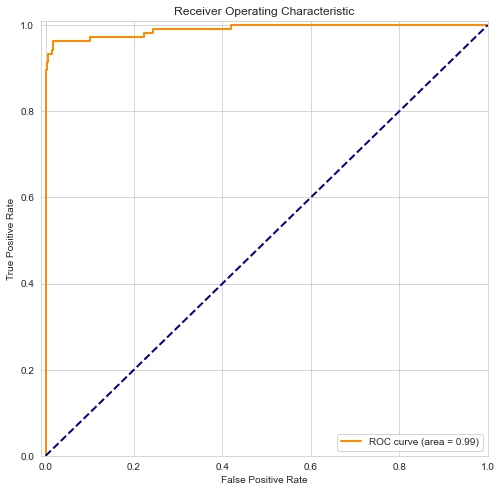

In [93]:
fig, ax = plt.subplots(figsize=(8, 8))
#plt.figure()
lw = 2
ax.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [94]:
fig.savefig('AUC-ROC.svg', format='svg', dpi=1200, bbox_inches='tight')